# Compile unitaries

> A short tutorial showing how to use the unitary compilation model.

In [ ]:
from genQC.imports import *
import genQC.utils.misc_utils as util

from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer
from genQC.platform.simulation import Simulator, CircuitBackendType
from genQC.inference.sampling import decode_tensors_to_backend, generate_compilation_tensors
from genQC.inference.evaluation_helper import get_unitaries
from genQC.inference.eval_metrics import UnitaryInfidelityNorm

from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

In [ ]:
device = util.infer_torch_device()  # use cuda if we can
util.MemoryCleaner.purge_mem()      # clean existing memory alloc

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


In [ ]:
# We set a seed to pytorch, numpy and python. 
# Note: This will also set deterministic algorithms, possibly at the cost of reduced performance!
util.set_seed(0)

## Setup and load

Load the pre-trained model directly from [Hugging Face: Floki00/qc_unitary_3qubit](https://huggingface.co/Floki00/qc_unitary_3qubit).

In [ ]:
pipeline = DiffusionPipeline.from_pretrained("Floki00/qc_unitary_3qubit", device)

Set 20 sample steps and use rescaled guidance-formula.

In [ ]:
pipeline.guidance_sample_mode = "rescaled"
pipeline.scheduler.set_timesteps(20) 
g = 10

The model was trained with a gate pool of:

In [ ]:
pipeline.gate_pool

['h', 'cx', 'z', 'x', 'ccx', 'swap']

In [ ]:
vocabulary = {g:i+1 for i, g in enumerate(pipeline.gate_pool)} 
tokenizer  = CircuitTokenizer(vocabulary)
simulator  = Simulator(CircuitBackendType.QISKIT)

## Compile a unitary

Compile a given unitary $U$. Note, there has to be a solution with the `pipeline.gate_pool` in order to find the exact solution.

In [ ]:
def compile_and_plot(U, prompt):
    U_r, U_i = torch.Tensor(np.real(U)), torch.Tensor(np.imag(U))
    U_tensor = torch.stack([U_r, U_i], dim=0)
    
    out_tensor = generate_compilation_tensors(pipeline, 
                                prompt=prompt, 
                                U=U_tensor, 
                                samples=samples, 
                                system_size=num_of_qubits, 
                                num_of_qubits=num_of_qubits, 
                                max_gates=max_gates, 
                                g=g, 
                                no_bar=False, 
                                tensor_prod_pad=False, 
                                enable_params=False)

    out_tensor = out_tensor.unique(dim=0)
    
    qc_list, error_cnt = decode_tensors_to_backend(simulator, tokenizer, out_tensor)

    approx_Us = get_unitaries(simulator, qc_list)
    approx_Us = torch.from_numpy(np.stack(approx_Us)).to(torch.complex128)
    target_Us = torch.complex(U_r, U_i).unsqueeze(0).to(torch.complex128)
    
    U_norms = UnitaryInfidelityNorm.distance(target_Us, approx_Us)

    corr = ( U_norms.abs() < 1.0e-3 )
    corr_qc = [qc for qc, c in zip(qc_list, corr) if c]
    corr_qc = sorted(corr_qc, key=lambda x: len(x.data)) # sort to get the shortest solutions

    fig, axs = plt.subplots(1,4, figsize=(12, 4), constrained_layout=True, dpi=150)
    axs[0].set_title(f"{prompt}")
    for qc,ax in zip(corr_qc, axs.flatten()): 
        qc.draw("mpl", plot_barriers=False, ax=ax)
    plt.show()

In [ ]:
samples       = 512
num_of_qubits = 3
max_gates     = 12

In [ ]:
prompt = "Compile using: ['h', 'cx', 'z', 'x', 'ccx', 'swap']" # model was trained with phrases like this, allow full gate set
prompt

"Compile using: ['h', 'cx', 'z', 'x', 'ccx', 'swap']"

#### Exercise 1

Inspired from [(quantumcomputing.stackexchange.com/questions/13821/generate-a-3-qubit-swap-unitary-in-terms-of-elementary-gates/13826)](https://quantumcomputing.stackexchange.com/questions/13821/generate-a-3-qubit-swap-unitary-in-terms-of-elementary-gates/13826). Note, this unitary WAS in the training set.

In [ ]:
U = np.matrix([[1,0,0,0,0,0,0,0],
               [0,1,0,0,0,0,0,0],
               [0,0,1,0,0,0,0,0],
               [0,0,0,0,1,0,0,0],
               [0,0,0,1,0,0,0,0],
               [0,0,0,0,0,1,0,0],
               [0,0,0,0,0,0,1,0],
               [0,0,0,0,0,0,0,1]], dtype=np.complex128) 

assert np.allclose(U.H@U, np.identity(2**num_of_qubits)) and np.allclose(U@U.H, np.identity(2**num_of_qubits)) #check if unitary

Plot correct (exact) compiled circuits:

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 512 tensors


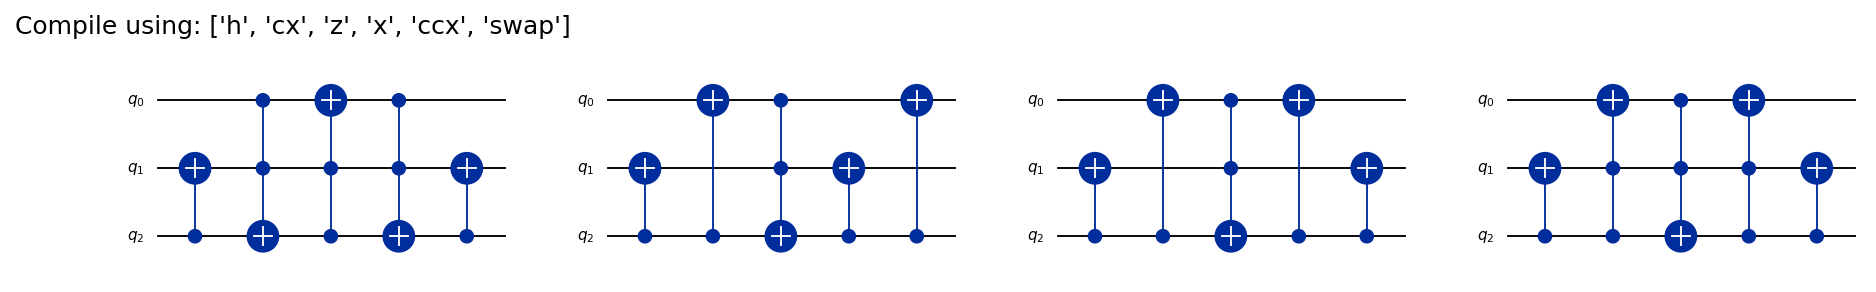

In [ ]:
compile_and_plot(U, prompt)

#### Exercise 2

Inspired from [(quantumcomputing.stackexchange.com/questions/12439/procedures-and-intuition-for-designing-simple-quantum-circuits/12440)](https://quantumcomputing.stackexchange.com/questions/12439/procedures-and-intuition-for-designing-simple-quantum-circuits/12440). Note, this unitary WAS in the training set.

In [ ]:
U = np.matrix([[1,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,1],
               [0,1,0,0,0,0,0,0],
               [0,0,1,0,0,0,0,0],
               [0,0,0,1,0,0,0,0],
               [0,0,0,0,1,0,0,0],
               [0,0,0,0,0,1,0,0],
               [0,0,0,0,0,0,1,0]], dtype=np.complex128) 

assert np.allclose(U.H@U, np.identity(2**num_of_qubits)) and np.allclose(U@U.H, np.identity(2**num_of_qubits)) #check if unitary

Plot correct (exact) compiled circuits:

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 512 tensors


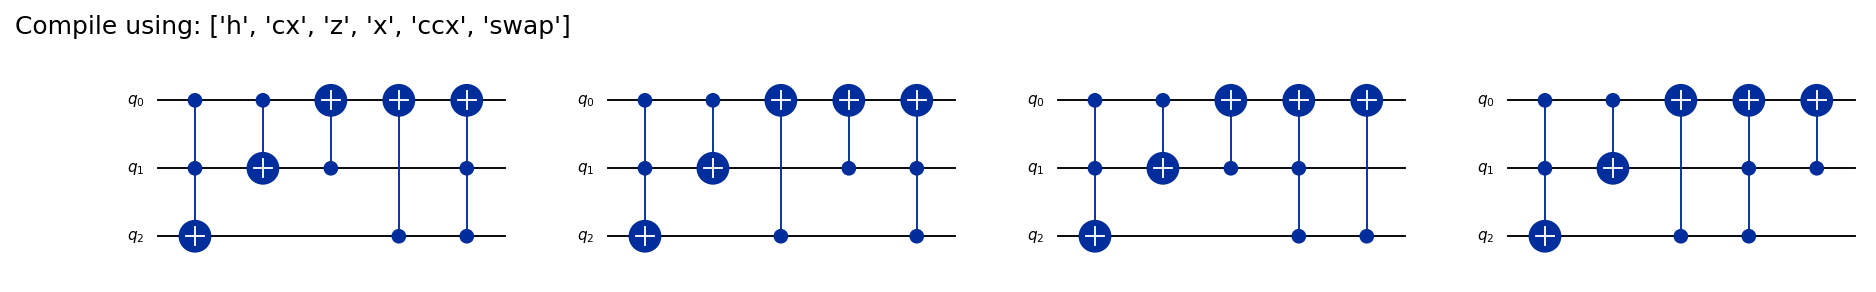

In [ ]:
compile_and_plot(U, prompt)

#### Exercise 3

A randomly generated unitary (from a random circuit). This unitary WAS NOT in the training set, it is new to the model!

In [ ]:
U = np.matrix([[ 0.70710678,  0.        ,  0.        , 0.        ,  0.70710678,  0.        , 0.        ,  0.        ],
               [ 0.        , -0.70710678,  0.        , 0.        ,  0.        , -0.70710678, 0.        ,  0.        ],
               [-0.70710678,  0.        ,  0.        , 0.        ,  0.70710678,  0.        , 0.        ,  0.        ],
               [ 0.        ,  0.70710678,  0.        , 0.        ,  0.        , -0.70710678, 0.        ,  0.        ],
               [ 0.        ,  0.        ,  0.70710678, 0.        ,  0.        ,  0.        , 0.        ,  0.70710678],
               [ 0.        ,  0.        ,  0.        , 0.70710678,  0.        ,  0.        , 0.70710678,  0.        ],
               [ 0.        ,  0.        , -0.70710678, 0.        ,  0.        ,  0.        , 0.        ,  0.70710678],
               [ 0.        ,  0.        ,  0.        ,-0.70710678,  0.        ,  0.        , 0.70710678,  0.        ]], dtype=np.complex128)

assert np.allclose(U.H@U, np.identity(2**num_of_qubits)) and np.allclose(U@U.H, np.identity(2**num_of_qubits)) #check if unitary

Plot correct (exact) compiled circuits:

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 512 tensors


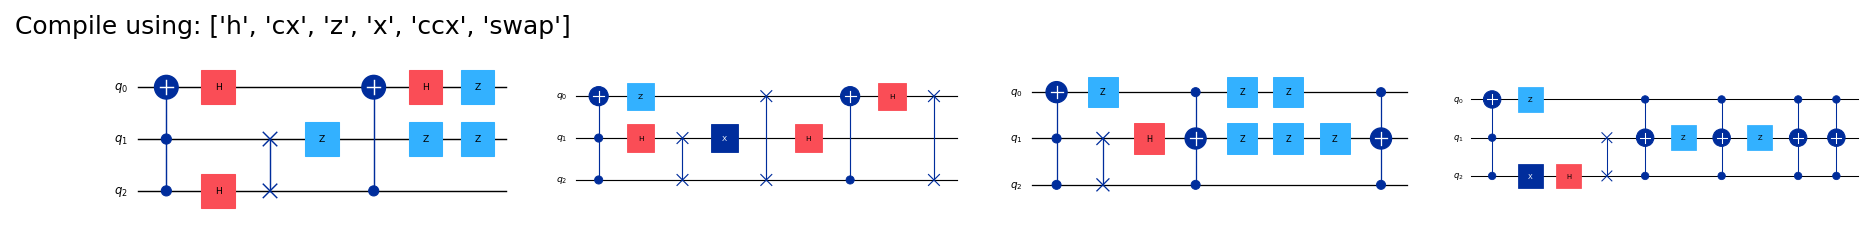

In [ ]:
compile_and_plot(U, prompt)

## Transpile and discover

Set an initial circuit we want to transpile, optimize or use for discovering sub-arrangements:

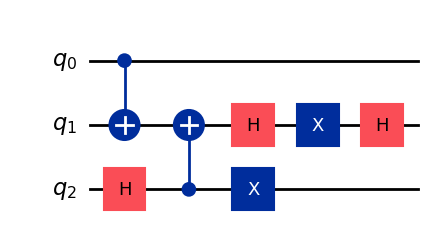

In [ ]:
qc = QuantumCircuit(3)
qc.h(2)
qc.cx(0,1)
qc.cx(2,1)
qc.h(1)
qc.x(1)
qc.h(1)
qc.x(2)

U = qi.Operator(qc).to_matrix() # the unitary of the circuit

#-----------------------------------------

fig = qc.draw("mpl")
fig

We set different gate pool targets to see what the model gives us:

In [ ]:
cs_1 = f"Compile using: {[x for x in pipeline.gate_pool]}", "all"

cs_2 = "Compile using: ['h', 'cx', 'z', 'ccx']" , "no x, no swap"    
cs_3 = "Compile using: ['h', 'cx', 'x', 'ccx']" , "no z, no swap"    
cs_4 = "Compile using: ['h', 'x', 'ccx']"       , "no cx, no z, no swap" 
cs_5 = "Compile using: ['h', 'z', 'x', 'ccx']"  , "no cx, no swap"  

cs = [cs_1, cs_2, cs_3, cs_4, cs_5]
cs

[("Compile using: ['h', 'cx', 'z', 'x', 'ccx', 'swap']", 'all'),
 ("Compile using: ['h', 'cx', 'z', 'ccx']", 'no x, no swap'),
 ("Compile using: ['h', 'cx', 'x', 'ccx']", 'no z, no swap'),
 ("Compile using: ['h', 'x', 'ccx']", 'no cx, no z, no swap'),
 ("Compile using: ['h', 'z', 'x', 'ccx']", 'no cx, no swap')]

In [ ]:
samples       = 512
num_of_qubits = 3
max_gates     = 12

Compile with the different gate-sets and plot correct (exact) compiled circuits. Note, some of the circuits might look the same but the gate time-sequences are distinct. Qiskit reorders "parallel" gates to make smaller plots.

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 512 tensors


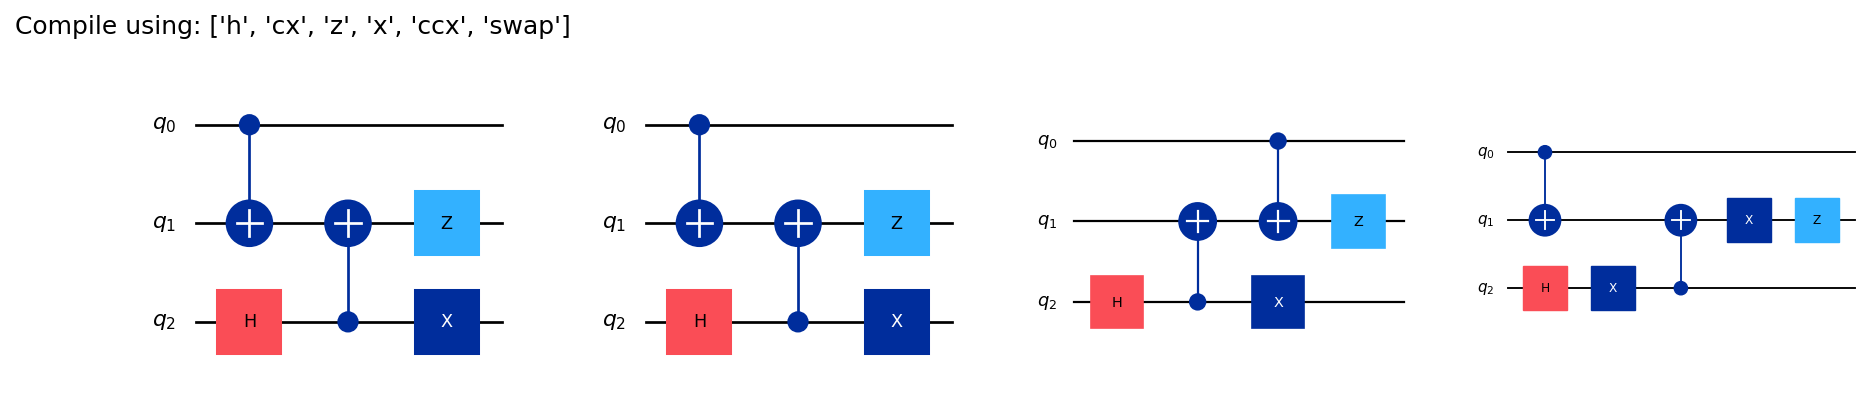

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 512 tensors


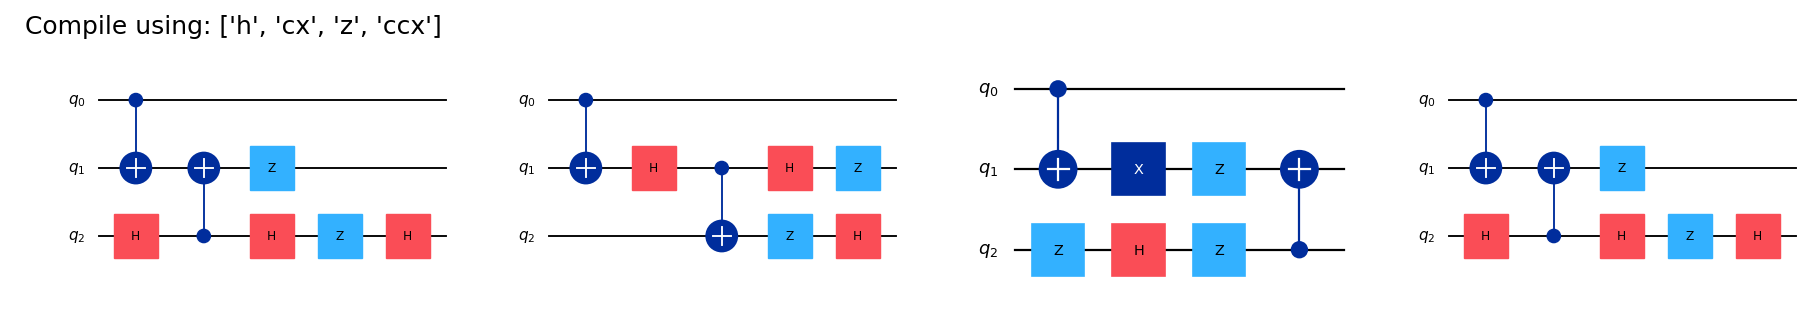

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 512 tensors


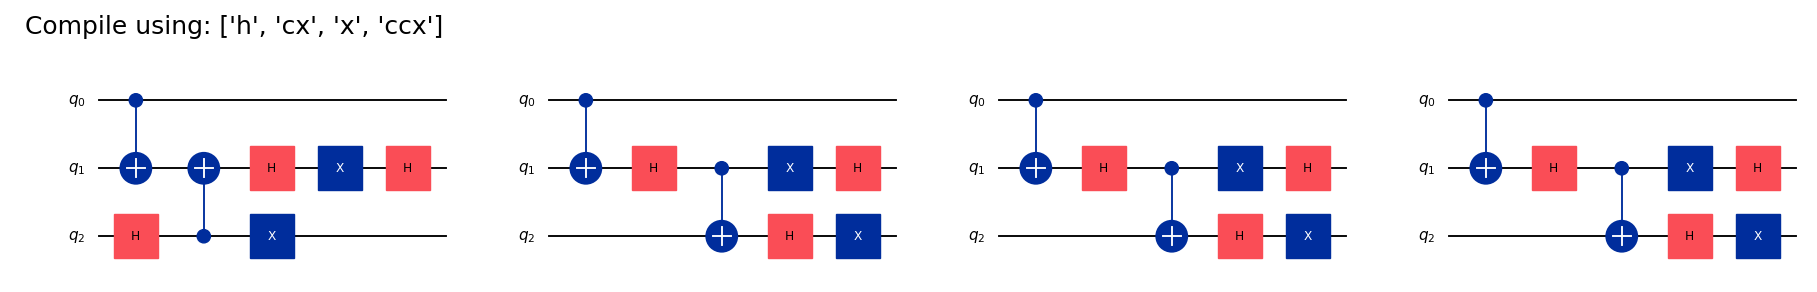

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 512 tensors


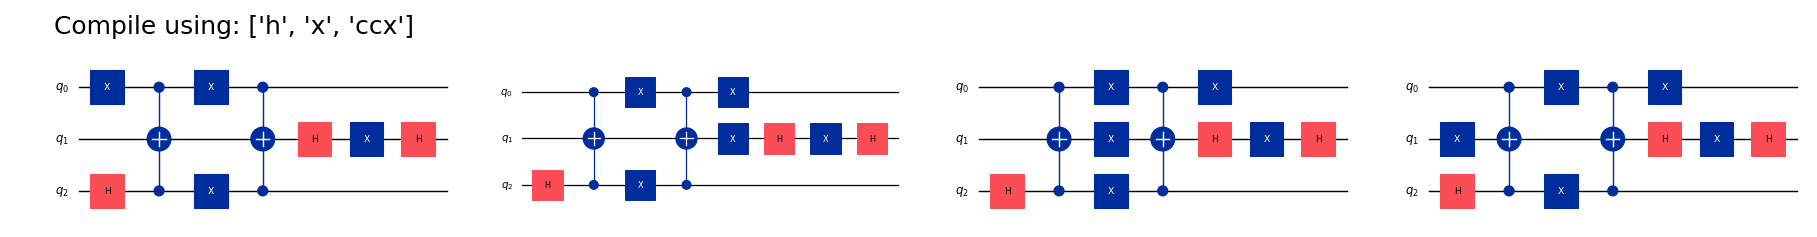

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 512 tensors


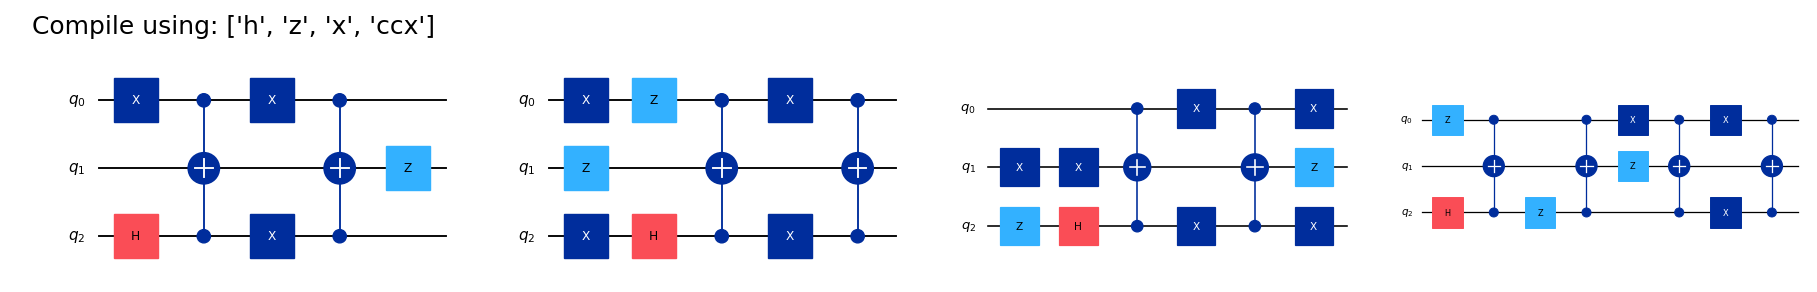

In [ ]:
for c, note in cs: compile_and_plot(U, c)

In [ ]:
import genQC
print("genQC Version", genQC.__version__)

genQC Version 0.2.0
